In [12]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as gg
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.transforms import Compose, ToTensor, ToPILImage, Lambda, Resize, Normalize
from tqdm import tqdm

from os import listdir, remove, rmdir, mkdir, path

from image_processing import model_application
from model_functions import train_torch, model_test_torch, ImageSet

%matplotlib inline

In [3]:
# Set up default data path
data_path = '../data/'
# Set up the available device
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
print(f"Device: {device}")

Device: mps


In [4]:
# Enable autoreload on notebook
%load_ext autoreload
%autoreload 2

# Transformations

In [5]:
# Image width, height
width, height = 1920, 1080
# Pre computed image normalization values
std = (0.25290563, 0.25075692, 0.24500758)
mean = (0.43378793, 0.39802867, 0.41464927)

ipt_trans = Compose((ToTensor(), 
                    Resize((height, width)), 
                    Normalize(mean=mean, std=std)
                    ))

target_trans = Compose((ToPILImage(),
                       Resize((height, width)),
                       ToTensor()
                       ))

# Creating Datasets and other objects

In [6]:
# Create train/test split of annotated dataset
all_files = [x for x in listdir(data_path + 'images/') if x.endswith('.jpg')]
train_split = 0.9
train_files, test_files = train_test_split(all_files, train_size=train_split, shuffle=True)
print(f"{len(train_files)}:{len(test_files)}")

# Create the Datasets
train_set = ImageSet(file_names=train_files, img_dir=data_path + 'images/', mask_dir=data_path + 'masks/', img_transform=ipt_trans, mask_transform=target_trans)
test_set  = ImageSet(file_names=test_files, img_dir=data_path + 'images/', mask_dir=data_path + 'masks/', img_transform=ipt_trans, mask_transform=target_trans)

# Create the DataLoaders
batch_size = 6
shuffle = True
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_set, batch_size=batch_size, shuffle=True)

# Create the new image sequence datasets
seq_set = ImageSet(file_names=[x for x in listdir(data_path + 'images/seq') if x.endswith('.jpg')], img_dir=data_path + 'images/seq/', img_transform=ipt_trans)
seq2_set = ImageSet(file_names=[x for x in listdir(data_path + 'images/seq2') if x.endswith('.jpg')], img_dir=data_path + 'images/seq2/', img_transform=ipt_trans)

# Create the new image sequence dataloaders
batch_size = 4
seq_loader = DataLoader(seq_set, batch_size=batch_size, shuffle=False)
seq2_loader = DataLoader(seq2_set, batch_size=batch_size, shuffle=False)

126:15


# Model
- First run will require downloading and modifying the classifier of resnet101.
- Subsequent runs can choose to load a saved model that has already been trained on the data

In [7]:
# False will load a pre-trained model, True will create a freshly initialized model.
new_model = False
if new_model:
    # Fetch model with weights
    fcn = torchvision.models.segmentation.fcn_resnet101(weights=torchvision.models.segmentation.FCN_ResNet101_Weights.DEFAULT)

    # Turn off gradient tracking for all layers
    for param in fcn.parameters():
        param.requires_grad = False

    # Replace final conv layer for two classes and turn on gradient tracking for classifier
    fcn.classifier[4] = torch.nn.Conv2d(512, 2, kernel_size=(1, 1), stride=(1, 1))
    for param in fcn.classifier.parameters():
        param.requires_grad = True

    # Move to device and make eval mode
    fcn = fcn.to(device)
    fcn.eval()
else:
    # Load a local pretrained model
    fcn = torch.load('./models/fcn')
    fcn.eval()

lossi = []

In [8]:
# Create optimizer and loss function
learning_rate = 0.00001
optim = torch.optim.Adam(params=fcn.classifier.parameters(), lr=learning_rate)

lossfn = torch.nn.CrossEntropyLoss()

## Training Model

In [9]:
# Train the model on the training dataset
train_model = False
epochs = 1
if train_model:
    for i in range(epochs):
        lossi.extend(train_torch(fcn, device, optim, lossfn, train_loader))
else:
    print("Not training model.")

Not training model.


In [10]:
# Plot the loss progression of the model
if len(lossi):
    plt.plot(lossi)

In [11]:
# Test the model loss
model_test_torch(fcn, device, lossfn, test_loader)

0.03395411744713783

# Applying the Model

In [78]:
# Set up the paths for images sources and destinations
# - mask and image destinations will be created if not present
image_src = data_path + 'images/seq2/'
mask_dest = image_src + 'masks/'
image_dest = image_src + 'out/'

# Optionally create the masks and then create the final predicted files
model_application(model=fcn, device=device, loader=seq2_loader, image_src=image_src, mask_dest=mask_dest, image_dest=image_dest,
                  skip_masks=True,
                  clear_mask_dest=False, clear_image_dest=True,
                  clean_up_mask_dest=False, clean_up_image_dest=False)

100%|██████████| 594/594 [00:14<00:00, 41.89it/s]


In [ ]:
# Create a gif from the images using imagemagick convert
# convert -resize 512x512 -delay 3 -loop 0 *.jpg test.gif

# Plot Example Images and Masks

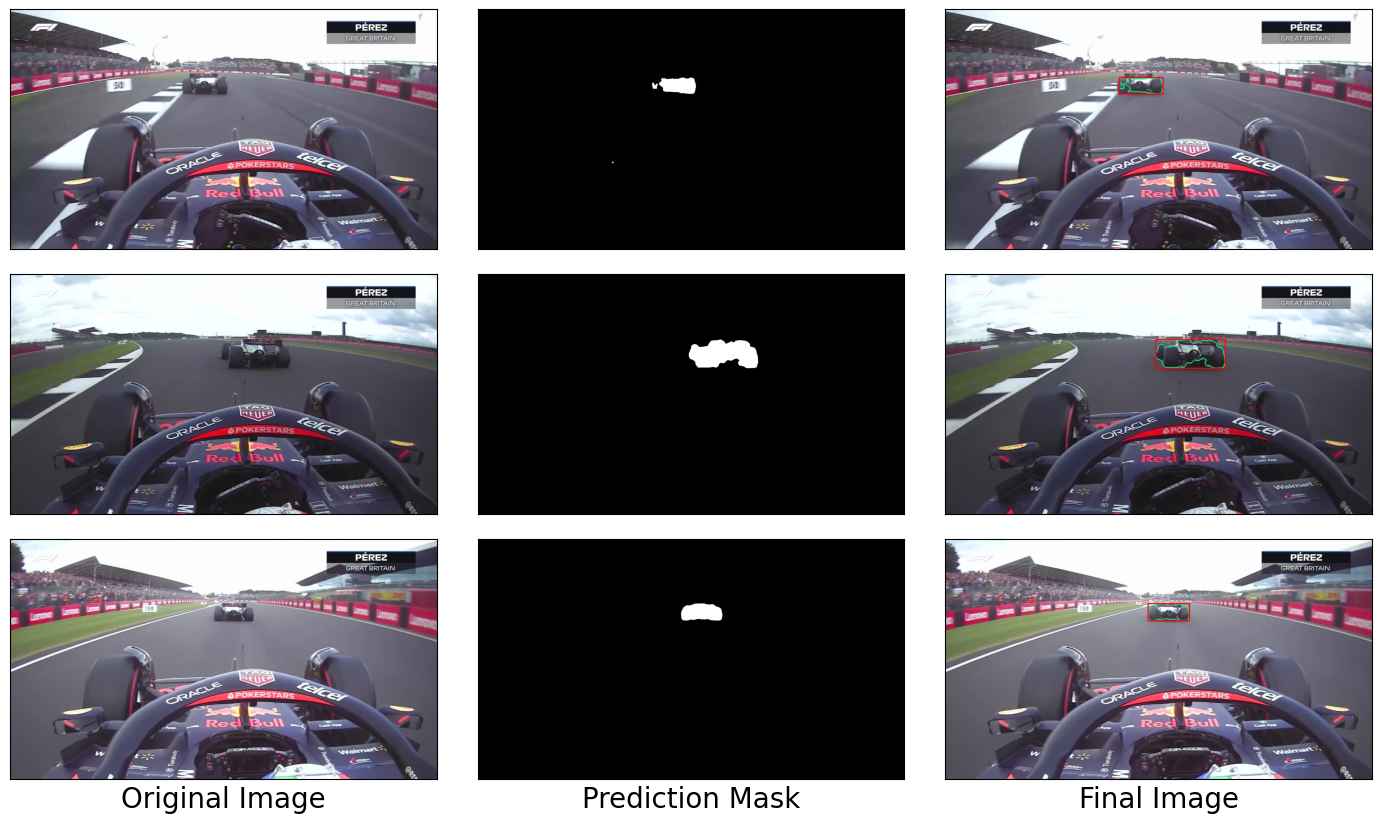

In [81]:
from mpl_toolkits.axes_grid1 import Grid

image_src = data_path + 'images/seq2/'
mask_dest = image_src + 'masks/'
image_dest = image_src + 'out/'

# Sample images
num_images = 3
images = np.random.choice([f for f in listdir(image_src) if f.endswith('.jpg')], num_images)

# Create Plot
figsize = 10
fig = plt.figure(figsize=(figsize * 16/9, figsize))
ax = Grid(fig, rect=111, nrows_ncols=(num_images, 3), axes_pad=0.25, label_mode='L')
# Formatting Figure
ax[-3].set_xlabel('Original Image', fontsize=20)
ax[-2].set_xlabel('Prediction Mask', fontsize=20)
ax[-1].set_xlabel('Final Image', fontsize=20)
for a in ax:
    a.set_xticks([])
    a.set_yticks([])

# Insert images
for i in range(num_images):
    ax[3*i+ 0].imshow(cv2.cvtColor(cv2.imread(image_src + images[i]), cv2.COLOR_BGR2RGB))
    ax[3*i+ 1].imshow(cv2.cvtColor(cv2.imread(mask_dest + images[i].replace('.jpg', '.png')), cv2.COLOR_BGR2RGB))
    ax[3*i+ 2].imshow(cv2.cvtColor(cv2.imread(image_dest + images[i]), cv2.COLOR_BGR2RGB))
